<a href="https://colab.research.google.com/github/tudi72/ECG_classification_AutoML/blob/main/27_septembrie_ecg_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# READING DATA

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# !sudo apt-get install build-essential swig
# !curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
# !pip install auto-sklearn
# !pip install mljar-supervised
# for _ in range(3):
#     try:
#         import autosklearn.classification
#         break
#     except:
#         pass
# else:
#     raise ImportError("failed to import from autosklearn")

()

In [ ]:
!pip install percentile
!pip install mljar-supervised
!pip install auto-sklearn

In [ ]:
from autosklearn.classification import AutoSklearnClassifier
from supervised.automl import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,mean_squared_error,roc_curve,auc
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [ ]:
id_8_100 = "1Xim7evxFbwexccQSGJn9fuJvPkL36cVJ"
id_8_200 = "1iumJyhmCETAgbvwlkQxSC2C47xOxT1YF"
id_8_233 = "1B1SOBhoWeJnlP6yhMd9o8zecl2pZ0qHR"
downloaded = drive.CreateFile({'id':id_8_200}) 
downloaded.GetContentFile('data_8_200_+200.csv')  
downloaded = drive.CreateFile({'id':id_8_233}) 
downloaded.GetContentFile('data_8_233.csv')  


In [ ]:

df = pd.read_csv("data_8_200_+200.csv")
df_233 = pd.read_csv("data_8_233.csv")

# SPLIT DATA into Train and Test

In [ ]:
print(df['Type'].value_counts())
print(df_233['Type'].value_counts())


0    69523
1    25996
Name: Type, dtype: int64
0    2229
1     848
Name: Type, dtype: int64


In [ ]:
MLII_X_global = df.iloc[:,5:405].values
MLII_y_global = df['Type'].values

MLII_X_train, MLII_X_test, MLII_y_train, MLII_y_test = train_test_split(MLII_X_global, MLII_y_global, train_size = .75)

In [ ]:
unique, counts = np.unique(MLII_y_test,return_counts=True)

print('Test - Healthy\t',counts[0],' Sick\t',counts[1])
unique, counts = np.unique(MLII_y_train,return_counts=True)
print('Train - Healthy\t',counts[0],' Sick\t',counts[1])

Test - Healthy	 17344  Sick	 6536
Train - Healthy	 52179  Sick	 19460


In [ ]:
automl = AutoML(
    mode='Perform',
    total_time_limit = 6000,
    ml_task="binary_classification",
    train_ensemble= True,
    eval_metric = "average_precision",
    explain_level = 1
    # algorithms = ["LightGBM"]
)

In [ ]:
automl.fit(MLII_X_train,MLII_y_train)

Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is binary_classification with evaluation metric average_precision
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 5 models
1_Default_LightGBM average_precision 0.996792 trained in 2669.99 seconds (1-sample predict time 0.1956 seconds)
* Step not_so_random will try to check up to 20 models
6_LightGBM average_precision 0.995894 trained in 1973.73 seconds (1-sample predict time 0.2181 seconds)
Skip golden_features because no parameters were generated.
Skip insert_random_feature because no parameters were generated.
Skip features_selection 

AutoML(eval_metric='average_precision', explain_level=1,
       ml_task='binary_classification', mode='Perform', total_time_limit=6000)

In [ ]:
  predictions_y_test_automl = automl.predict_all(MLII_X_test)
  predictions_y_train_automl = automl.predict_all(MLII_X_train)
  accuracy_train_automl = accuracy_score(MLII_y_train,predictions_y_train_automl["label"])
  accuracy_test_automl = accuracy_score(MLII_y_test,predictions_y_test_automl["label"])

In [ ]:
print("train accuracy ",accuracy_train_automl," test accuracy ", accuracy_test_automl)

train accuracy  1.0  test accuracy  0.990033500837521


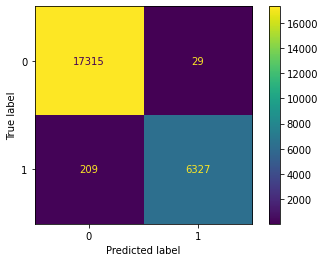

In [ ]:
fpr, tpr, thresholds = roc_curve(MLII_y_test, predictions_y_test_automl["label"])
cm = confusion_matrix(MLII_y_test,predictions_y_test_automl["label"])
tn,fn,fp,tp = confusion_matrix(MLII_y_test,predictions_y_test_automl["label"]).ravel()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
AUC = auc(fpr, tpr)
Precision = tp / (tp+fp)
Recall = tp / (tp + fn)
F1 = 2 * (Precision * Recall) / (Precision + Recall)

In [ ]:
AUC = auc(fpr, tpr)
Precision = tp / (tp+fp)
Recall = tp / (tp + fn)

print('Precision   \t\t',Precision)
print('Recall   \t\t',Recall)
print('AUC      \t\t',AUC)
print('Accuracy test\t\t',accuracy_test_automl)
print('Accuracy train\t\t',accuracy_train_automl)
print('tn: ',tn,'fn ',fn,'fp ',fp,'tp ',tp)

Precision   		 0.9680232558139535
Recall   		 0.9954373820012586
AUC      		 0.983175603921737
Accuracy test		 0.990033500837521
Accuracy train		 1.0
tn:  17315 fn  29 fp  209 tp  6327


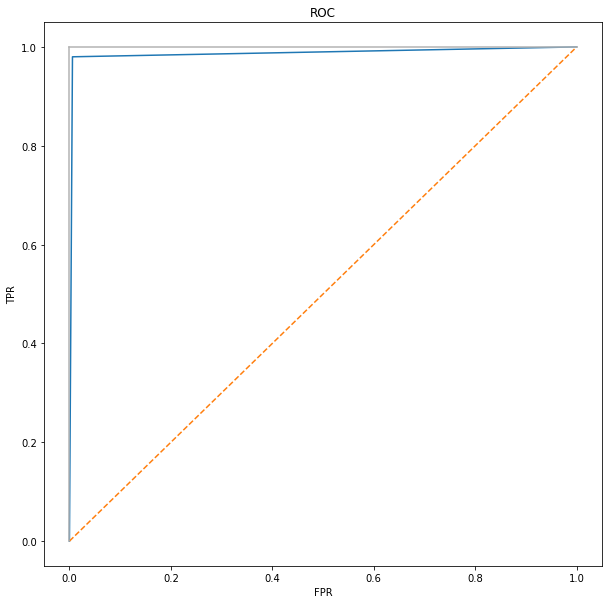

In [ ]:
fpr, tpr, thresholds = roc_curve(MLII_y_test, predictions_y_test_automl["label"])
plt.subplots(1, figsize=(10,10))
plt.title('ROC')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7")
plt.plot([1, 1] , c=".7")
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

# Patient 233

In [ ]:
MLII_X_test_233 = df_233.iloc[:,5:405].values
MLII_y_test_233 = df_233['Type'].values
predictions_y_test_233 = automl.predict_all(MLII_X_test_233)

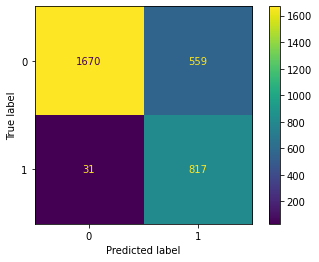

In [ ]:
cm_233 = confusion_matrix(MLII_y_test_233,predictions_y_test_233["label"])
disp_233 = ConfusionMatrixDisplay(confusion_matrix=cm_233)
disp_233.plot()

In [ ]:
accuracy_test_233 = accuracy_score(MLII_y_test_233,predictions_y_test_233["label"])
tn,fn,fp,tp = confusion_matrix(MLII_y_test_233,predictions_y_test_233["label"]).ravel()
AUC = auc(fpr, tpr)
Precision = tp / (tp+fp)
Recall = tp / (tp + fn)

print('Precision   \t\t',Precision)
print('Recall     \t\t',Recall)
print('AUC      \t\t',AUC)
print('Accuracy test\t\t',accuracy_test_233)
print('tn: ',tn,'fn ',fn,'fp ',fp,'tp ',tp)

Precision   		 0.9634433962264151
Recall     		 0.59375
AUC      		 0.983175603921737
Accuracy test		 0.8082547936301593
tn:  1670 fn  559 fp  31 tp  817


# AUTOSKLEARN LIBRARY

In [ ]:
MLII_X_global = df.iloc[:,5:405].values
MLII_y_global = df['Type'].values

MLII_X_train, MLII_X_test, MLII_y_train, MLII_y_test = train_test_split(MLII_X_global, MLII_y_global, train_size = .75)

In [ ]:

model = AutoSklearnClassifier(time_left_for_this_task=60*60,memory_limit= 30000)
model.fit(MLII_X_train,MLII_y_train)

[WARNING] [2022-10-09 16:26:18,410:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-10-09 16:26:24,909:Client-EnsembleBuilder] No runs were available to build an ensemble from


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=30000, per_run_time_limit=360)

In [ ]:
MLII_y_pred_test = model.predict(MLII_X_test)
MLII_y_pred_train = model.predict(MLII_X_train)


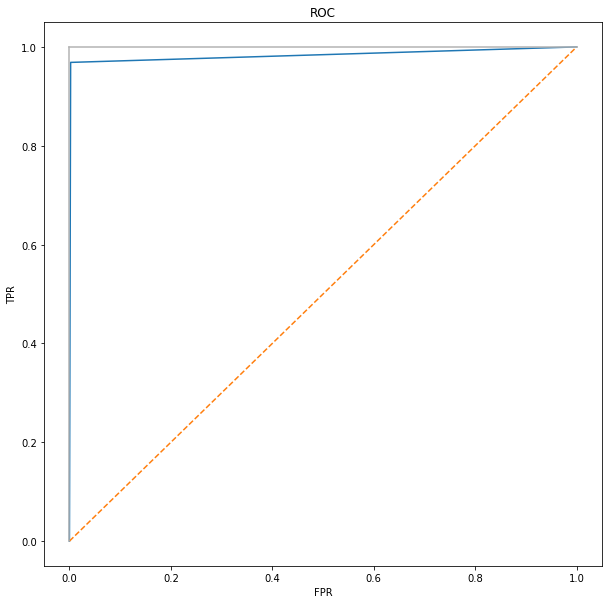

In [ ]:
fpr, tpr, thresholds = roc_curve(MLII_y_test, MLII_y_pred_test)
AUC = auc(fpr, tpr)

plt.subplots(1, figsize=(10,10))
plt.title('ROC')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7")
plt.plot([1, 1] , c=".7")
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [ ]:
accuracy_train = accuracy_score(MLII_y_train, MLII_y_pred_train)
accuracy_test = accuracy_score(MLII_y_test, MLII_y_pred_test)
tn,fp,fn,tp = confusion_matrix(MLII_y_test,MLII_y_pred_test).ravel()

Precision = tp / (tp+fp)
Recall = tp / (tp + tn)
F1 = 2 * (Precision * Recall) / (Precision + Recall)
print('Precision   \t\t',Precision)
print('Recall   \t\t',Recall)
print('AUC      \t\t',AUC)
print("F1       \t\t",F1)
print('Accuracy test\t\t',accuracy_test)
print('Accuracy train\t\t',accuracy_train)

Recall   		 0.9934775692014
Sensitivity		 0.2642044252654736
AUC      		 0.996680036740811
F1       		 0.4174046719914447
Accuracy test		 0.9898241206030151
Accuracy train		 0.9966359106073508


In [ ]:
print('tn: ',tn,'fp ',fp,'fn ',fn,'tp ',tp)

tn:  17392 fp  41 fn  202 tp  6245


In [ ]:
print(model.leaderboard())

          rank  ensemble_weight               type      cost    duration
model_id                                                                
16           1             0.20  gradient_boosting  0.010744  100.110121
4            2             0.40  gradient_boosting  0.011167   60.934243
5            3             0.06  gradient_boosting  0.013578  145.978450
18           4             0.30        extra_trees  0.018020  121.168320
14           5             0.04                mlp  0.048898   88.747553
